# Import pour data desc

Si on arrive à ces performances on est satisfait :


In [138]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scoring as sc
import seaborn as sns
%matplotlib inline
import importlib
importlib.reload(sc)
import warnings
warnings.simplefilter(action='ignore')


# Import des données et exploration

In [139]:
df = pd.read_csv('data/revenus.csv')

# Premier cycle :  
## Définition et nomenclature des données 

2. Traiter les données aberrantes 
3. Présenter les liaisons/corrélations avec la variable cible 
4. Entraîner les modèles 
5. Présenter et interpréter les résultats des métriques de qualité

In [160]:
pd.crosstab(df['gender'],df['relationship'])
#4 données abbérantes
df=df.drop(df[df['relationship']=='Husband'][df['gender']=='Female'].index)
df=df.drop(df[df['relationship']=='Wife'][df['gender']=='Male'].index)

In [162]:
#traitement des données aberrantes
extr=''
for i in df:
    extr+=f'{i} : {df[i].unique()}'+'\n' 
with open('output/vars_and_mods.txt','w') as f :
    f.write(extr)
#Recherche dans chaques variables de modalités qui n'irait pas dedans

Pas de valeurs aberrantes
# Corrélations

https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix

<Axes: >

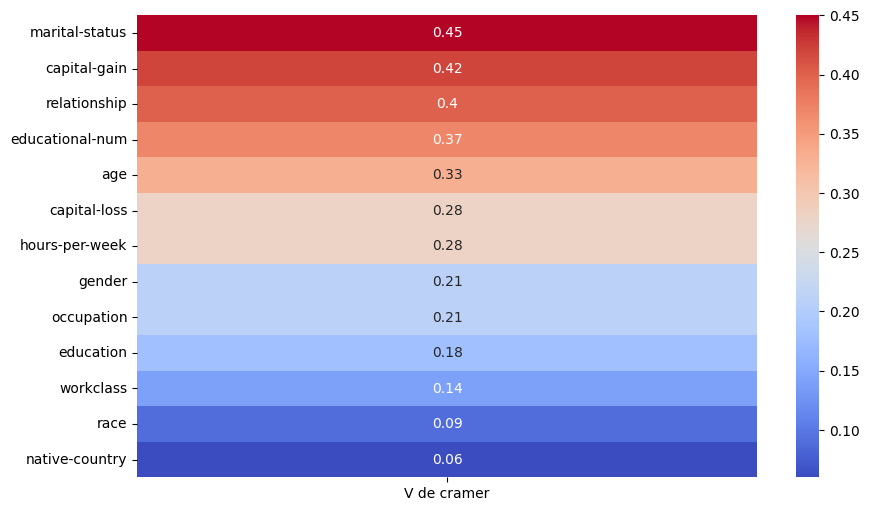

In [163]:
from scipy.stats import chi2_contingency
import numpy as np

df_cramer=pd.get_dummies(df)

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

rows= []
data={}
for var1 in df_cramer:
  cramers =cramers_V(df_cramer[var1], df_cramer['income_<=50K']) # Cramer's V test
  data[var1]=float(round(cramers,2)) # Keeping of the rounded value of the Cramer's V
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Créer un DataFrame avec les valeurs triées
df_sorted = pd.DataFrame(data=sorted_data, index=['V de cramer'])

#Regrouper le résultat par variables
df_transposed = df_sorted.T.reset_index()
df_transposed['split_index'] = df_transposed['index'].apply(lambda x: x.split('_')[0])
grouped_df = df_transposed.groupby('split_index')['V de cramer'].max()
data={}
for i in range(len(list(grouped_df.index))):
  data[list(grouped_df.index)[i]]=grouped_df.values[i]
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
df_sorted = pd.DataFrame(data=sorted_data, index=['V de cramer'])
# Afficher le heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_sorted.T[2:], cmap='coolwarm',annot=True)

On supprimera alors fnlwgt après le premier entrainement. Il en est de même pour educational-num, il représente la même chose que education

# Entraîner les modèles

In [164]:
res_all=sc.all_calc(df)

In [165]:
print(sc.fancy_dico(res_all))

Arbre de décision
     accuracy : 0.6 
     auc : 0.74 
     Gauc : 0.74 
     f1-score : 0.61 
Logistique
     accuracy : 0.58 
     auc : 0.62 
     Gauc : 0.8 
     f1-score : 0.41 



# Premier traitement


## REGROUPEMENT ET SUPPRESSION DE VARIABLES

In [166]:
df_regroup=df.copy()
df_regroup['native-country']=df_regroup['native-country'].apply(lambda x : 'USA' if x=='United-States' else 'OTHER')
df_regroup['capital-gain']+=df_regroup['capital-loss']*(-1)
df_regroup=df_regroup.drop('capital-loss',axis=1)
sup_var=['fnlwgt','educational-num','native-country','race']
calc_col=[i for i in df.columns if i not in ['capital-loss','capital-gain','age','educational-num','income','hours-per-week'] and i not in sup_var]
calc_col.append('income')
interest=['income','>50K']
df_regroup=sc.clean_df(df_regroup,sup_var)
sup_reg=['age', 'workclass', 'fnlwgt', 'education','marital-status', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
dico_regroup=[]
for i in range(10):
    dico_regroup.append(sc.regroupement(df_regroup,sup_reg,interest))
    df_regroup=sc.process_datacleaning(df_regroup,dico_regroup[len(dico_regroup)-1])

In [167]:
#Pour voir les regroupements faits par l'algo
with open('output/dico_regroup.txt','w') as f :
    f.write(sc.fancy_dico(dico_regroup))

age


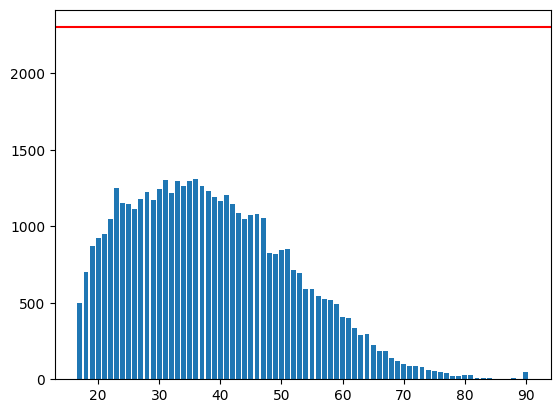

workclass


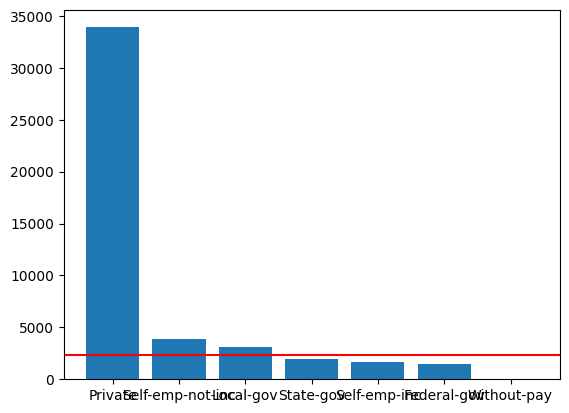

education


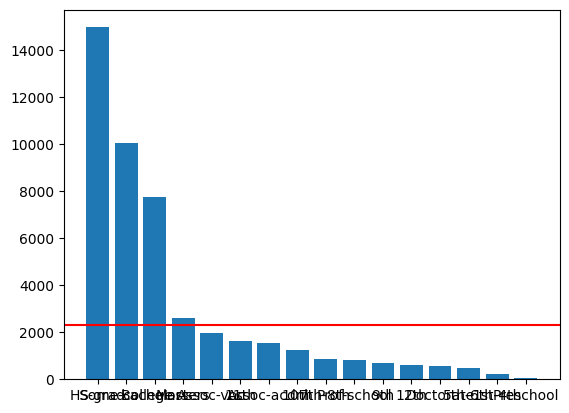

marital-status


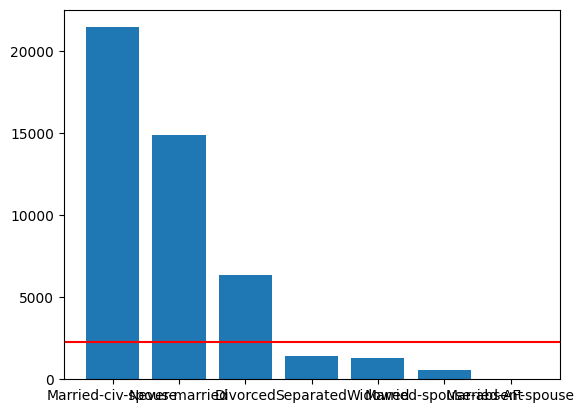

occupation


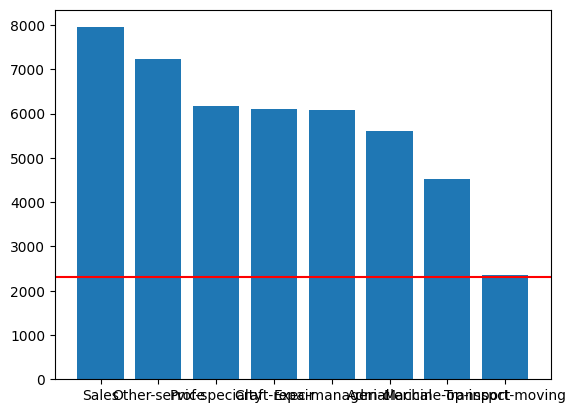

relationship


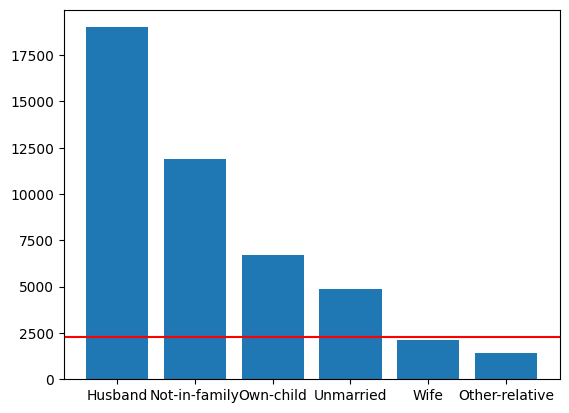

gender


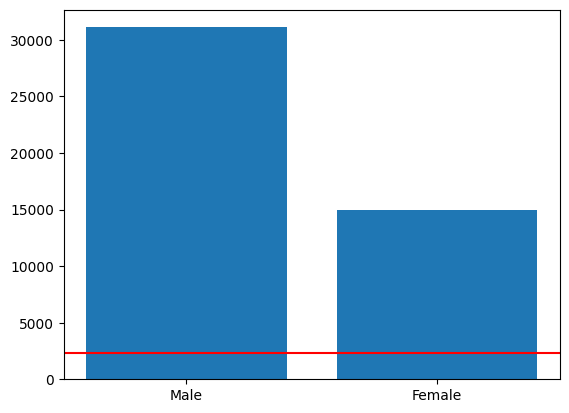

capital-gain


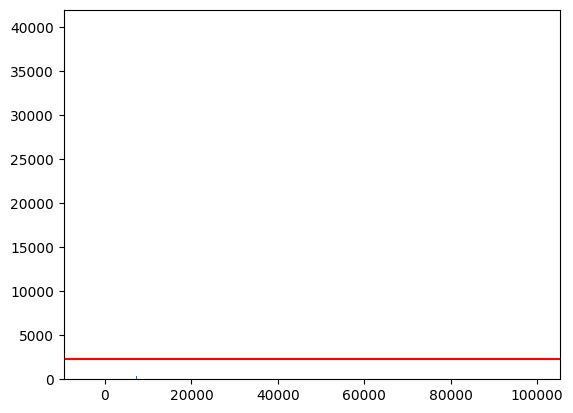

hours-per-week


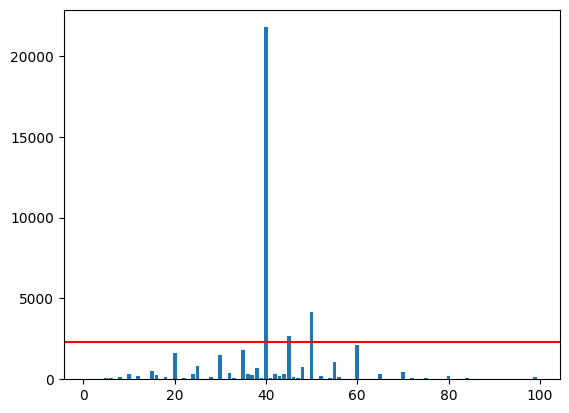

income


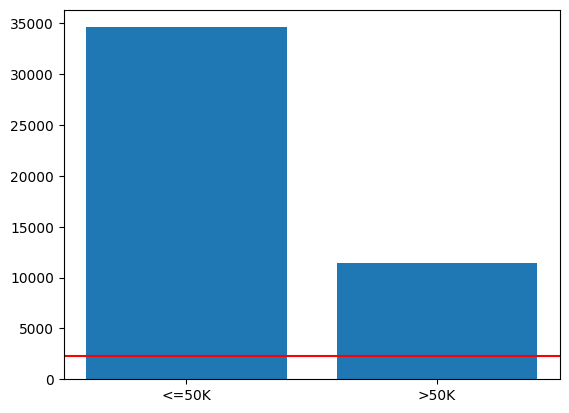

In [168]:
#Pour voir les regroupements faits
sc.show_repartition(df_regroup)

# Comparaison des modèles, nette amélioration

In [169]:
res_reg=sc.all_calc(df_regroup,cols=calc_col)

In [170]:
#Résultats après regroupement et traitement
print(sc.fancy_dico(res_reg))

Arbre de décision
     accuracy : 0.65 
     auc : 0.75 
     Gauc : 0.78 
     f1-score : 0.63 
Logistique
     accuracy : 0.72 
     auc : 0.75 
     Gauc : 0.89 
     f1-score : 0.65 



In [171]:
#Résultats sans traitement
print(sc.fancy_dico(res_all))

Arbre de décision
     accuracy : 0.6 
     auc : 0.74 
     Gauc : 0.74 
     f1-score : 0.61 
Logistique
     accuracy : 0.58 
     auc : 0.62 
     Gauc : 0.8 
     f1-score : 0.41 



# HYPERPARAMETRE TUNING

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
grid_log={'C': [0.1, 1.0, 10.0, 100.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'l1']
}
scoring=['roc_auc','f1','accuracy']
n_job=4
decision_tree=GridSearchCV(DecisionTreeClassifier(),grid_tree,n_jobs=n_job,scoring=scoring,refit='f1')
logit=GridSearchCV(LogisticRegression(max_iter=100),grid_log,n_jobs=n_job,scoring=scoring,refit='f1')
models=[(decision_tree,'Arbre de décision'),(logit,'Logistique')]

In [173]:
sav=sc.all_calc(df_regroup,models,top_cv=True,cols=calc_col)

# Resultats finaux :

In [174]:
res=[('Sans traitement\n',res_all),('Avec regroupement\n',res_reg),('Regroupement et tunning\n',sav)]
txt=''
for i in res:
    print(i[0],'\n',sc.fancy_dico(i[1]),'\n','#'*100)
    txt+=i[0]+' '+sc.fancy_dico(i[1])+'\n'+'#'*100
with open('output/finals_res.txt','w') as f :
    f.write(txt)

Sans traitement
 
 Arbre de décision
     accuracy : 0.6 
     auc : 0.74 
     Gauc : 0.74 
     f1-score : 0.61 
Logistique
     accuracy : 0.58 
     auc : 0.62 
     Gauc : 0.8 
     f1-score : 0.41 
 
 ####################################################################################################
Avec regroupement
 
 Arbre de décision
     accuracy : 0.65 
     auc : 0.75 
     Gauc : 0.78 
     f1-score : 0.63 
Logistique
     accuracy : 0.72 
     auc : 0.75 
     Gauc : 0.89 
     f1-score : 0.65 
 
 ####################################################################################################
Regroupement et tunning
 
 Arbre de décision
     best params : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10} 
     associed f1-score : {'accuracy': 0.77, 'auc': 0.77, 'Gauc': 0.9, 'f1-score': 0.67} 
Logistique
     best params : {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'} 
     associed f1-score : {'accuracy': 0.73, 'auc': 0.7

# PREDICTION AVEC LA NOUVELLE DATA

In [175]:
importlib.reload(sc)
df_newdata=pd.read_csv('data/nouvelle_data.csv')
df_newdata['native-country']=df_newdata['native-country'].apply(lambda x : 'USA' if x=='United-States' else 'OTHER')
df_newdata['capital-gain']+=df_newdata['capital-loss']*(-1)
df_newdata=df_newdata.drop('capital-loss',axis=1)
print(len(df_newdata[df_newdata['workclass']=='Never-worked']))
print(len(df_newdata['workclass']))
df_newdata=df_newdata.drop(df_newdata[df_newdata['workclass']=='Never-worked'].index) #Parce que nous avons supprimé tout ce qui avait des ?
df_newdata=sc.clean_df(df_newdata,sup_var)
for i in range(5):
    df_newdata=sc.process_datacleaning(df_newdata,dico_regroup[i])

1066
9681


In [176]:
prediction=sc.all_calc(df_regroup,new_data=df_newdata,models=models,cols=calc_col)
prediction

{'Arbre de décision': [array([False, False, False, ..., False, False, False]),
  'Arbre de décision'],
 'Logistique': [array([False, False, False, ..., False, False, False]),
  'Logistique']}

In [177]:
df_newdata['Pred_Logit']=prediction['Logistique'][0]
df_newdata['Pred_Arbre']=prediction['Arbre de décision'][0]
df_newdata.to_csv('output/df_pred_newdata.csv')

In [178]:
print('Prediction logistique :',df_newdata['Pred_Logit'].value_counts()/sum(df_newdata['Pred_Logit'].value_counts()),'\n',
      'Prediction arbre :',df_newdata['Pred_Arbre'].value_counts()/sum(df_newdata['Pred_Arbre'].value_counts()),'\n',
      'Données réelle :',df_regroup['income'].value_counts()/sum(df_regroup['income'].value_counts()),'\n',
      )

Prediction logistique : Pred_Logit
False    0.853652
True     0.146348
Name: count, dtype: float64 
 Prediction arbre : Pred_Arbre
False    0.774262
True     0.225738
Name: count, dtype: float64 
 Données réelle : income
<=50K    0.751874
>50K     0.248126
Name: count, dtype: float64 



In [179]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(df_newdata.Pred_Logit,df_newdata.Pred_Arbre))

,0,1
0,5090,953
1,391,645


# Scoring.py

In [180]:
################################################################################################################################################
############ Modules importés
################################################################################################################################################

from sklearn.tree import plot_tree
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

################################################################################################################################################
############ FONCTION POUR CALCULE ET PREDICTION DES MODELES
################################################################################################################################################

def score(X_train,X_test,y_train,y_test,model):
    """
    Affichage des metrics
    """
    return {'accuracy' :        round(float(metrics.precision_score(y_test,model.predict(X_test))),2),
                   'auc' :      round(float(metrics.roc_auc_score(y_test,model.predict(X_test))),2),
                   'Gauc' :      round(float(metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1], average='weighted')),2),
                   'f1-score' : round(float(metrics.f1_score(y_test,model.predict(X_test))),2)}

def score_cv(X_train,X_test,y_train,y_test,trained_model):
    return {'best params': trained_model.best_params_,
            'associed f1-score': score(X_train,X_test,y_train,y_test,trained_model)}


def all_calc(df,
             models=[(DecisionTreeClassifier(),'Arbre de décision'),(LogisticRegression(),'Logistique')],
             top_cv=False,
             test_size=0.33,
             rnd_state=11,
             new_data=None,
             cols=['workclass', 'education', 'marital-status', 'occupation','relationship', 'race', 'gender','native-country', 'income'],
             plot=False):
    """
    Segmente le jeu de données en train test size si besoin
    puis peut faire les predictions ou les scores dépendamment du besoin
    """
    df=pd.get_dummies(df,columns=cols)
    X=df[df.columns[:-2]]
    y=df['income_>50K']
    if new_data is None:
        X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=test_size,random_state=rnd_state)
    else:
        X_train,y_train=(X,y)
    ret={}
    for i in models:
        i[0].fit(X_train,y_train)
        if new_data is None:
            if top_cv==True:
                ret[i[1]]=score_cv(X_train,X_test,y_train,y_test,i[0])
            else:
                ret[i[1]]=score(X_train,X_test,y_train,y_test,i[0])
        if new_data is not None:
            ret[i[1]]=[i[0].predict(pd.get_dummies(new_data,columns=cols[:-1])),i[1]]
        if plot == True and i[1]=='Arbre de décision':
            plot_tree(i[0])
    return ret

################################################################################################################################################
############ FONCTION POUR TRAITEMENT DE DONNEES
################################################################################################################################################


def randint_exc(liste, exception):
    """
    Permet de faire un choix aléatoire dans une liste mis à part exception
    """
    res = random.choice(liste)
    while res == exception:
        res = random.choice(liste)
    return res

def repartition(df,i,interest):
    """
    Permet de savoir les modalitées à regrouper
    Puis calcule la répartition de chaques modalitées dépendamment de la variable expliquée pour la regle de decision
    """
    a_reg = []
    for m in df[i].unique():
        if sum(df[i] == m)/len(df[i]) <   0.05: # Si la modalité est inférieur au seuil
            a_reg.append(m) #On la met dans notre liste de modalités à regrouper
    cache = pd.crosstab(df[i], df[interest[0]])[interest[1]]# On calcule la répartition de chaques modalités dépendamment de la variable expliquée
    for ii in cache.index:
        cache[ii] = round(cache[ii] / sum(df[i] == ii), 3) # On divise par son nombre pour avoir une proportion et pr pouvoir comparer
    return cache,a_reg


def regroupement(df, sup, interest):
    """
    Fonction permettant de construire les dictionnaires de regroupement de variables à l'aide de la règle de décision suivante:
        regroupe une variable sous le seuil de rareté 0.05 avec 
        la variable ayant la répartition la plus semblable dépendamment 
        de la variable expliquée
    """
    regroup = {}
    for i in df.columns:
        if i not in sup:
            cache,a_reg=repartition(df,i,interest)
            reg = {}
            for sav in a_reg:
                val = cache[sav]
                savsav = randint_exc(df[i].unique(),sav) #Ici on choisi une modalité au hasard pour initialiser le minimum (on exlu la modalité analysée)
                for m in cache.index:
                    if abs(val - cache[m]) < abs(val - cache[savsav]) and sav!=m: #ici regle de décision
                        savsav = m
                reg[sav] = savsav
            regroup[i] = reg
    return regroup


def regroupement_dataframe(df,dico):
    """
    permet de faire le regroupement
    """
    for k,v in dico.items():
        for kk,vv in v.items():
            df[k]=df[k].replace(kk,vv)
    return df

def clean_df(df,too_much):
    """
    fonction permettant de clean le dataset, supprimer les colonnes non voulues... etc
    c'est ici qu'on fait le choix de supprimer toutes les personnes ne travaillant pas
    """
    return df.replace('?', np.nan).dropna().reset_index(drop=True).drop(too_much, axis=1)


def process_datacleaning(df,dico):
    """
    permet de faire le regroupement de variables en une fonction et en répétant le replace au cas ou
    """
    df_reg=df.copy()
    #df_reg=clean_df(df_reg,sup_var)
    for i in range(2):
        df_reg=regroupement_dataframe(df_reg,dico)
    return df_reg

################################################################################################################################################
############ FONCTION POUR REPRESENTATION DE VARIABLES
################################################################################################################################################

def show_repartition(df_regroup):
    """
    Montre la répartition des individus dans les modalités de chaque variable
    """
    for i in df_regroup.columns:
        col=i
        index= df_regroup[col].value_counts().index
        values=df_regroup[col].value_counts()
        plt.bar(index,values)
        plt.axhline(len(df_regroup)*0.05,color='red')
        print(i)
        plt.show()

def fancy_dico(dico):
    """
    Fonction pour rendre plus compréhensible la lecture des dictionnaires 
    de dictionnaires ou les listes de dictionnaires de dictionnaitres
    """
    rep=''
    if type(dico)==list:
        for dicoco in range(len(dico)):
            rep+=f"Itération numéro {dicoco + 1}" +'\n'
            for key,values in dico[dicoco].items():
                rep+=' '*5+key+'\n'
                for key,value in values.items():
                    rep+=' '*10+f'{key} : {value} '+'\n'
    else:
        for key,values in dico.items():
            rep+=key+'\n'
            for key,value in values.items():
                rep+=' '*5+f'{key} : {value} '+'\n'
    return rep